In [4]:
import re
import pandas as pd
import numpy as np
import time

from collections import defaultdict
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.sparse import csr_matrix, diags
from scipy.special import logsumexp
from scipy.sparse.linalg import svds

In [5]:
# Using default token pattern from sklearn
token_pattern = re.compile(r"(?u)\b\w\w+\b")
ngram_range = (1, 3)
min_freq = 10

In [6]:
df = pd.read_csv("yelp_review_sentiment_2classes.tsv", delimiter="\t")
df = df.dropna()

## train_test_split Implementation

In [7]:
def split_data(X, y, test_size=0.1):
    total_data = len(X)
    total_test = int(total_data * test_size)
    sample_idx = np.arange(total_data)
    np.random.shuffle(sample_idx)

    X_train = X.iloc[sample_idx[total_test:]]
    y_train = y.iloc[sample_idx[total_test:]]

    X_test = X.iloc[sample_idx[:total_test]]
    y_test = y.iloc[sample_idx[:total_test]]
    return (X_train, y_train), (X_test, y_test)

In [8]:
(X_train, y_train), (X_test, y_test) = split_data(df["text"], df["sentiment"])

In [9]:
X_train.shape, X_test.shape

((224981,), (24997,))

## CountVectorizer Implementation

Something weird happen with sklearn's CountVectorizer

Result from CountVectorizer. 
'beer', 'beer copyright', 'burger', 'copyright'  
6 4 5 5  

The correct one should be  
'beer', 'pizza', 'beer copyright', 'burger', 'copyright'  
6 4 4 5 5  
Pizza is missing from the transformation

In [10]:
en_stopwords = stopwords.words('english') + ["-PRON-", "-pron-", "PRON", "pron"]

def preprocessing(text, ngram_range):
    tokens = token_pattern.findall(text)
    tokens = list(filter(lambda x: x not in en_stopwords, tokens))
    tokens = build_ngrams(tokens, ngram_range)
    return tokens


def build_ngrams(text, ngram_range):
    vocabs = []
    join_space = " ".join
    for i in range(ngram_range[0], ngram_range[1] + 1):
        for j in range(len(text)):
            if j + i <= len(text):
                vocabs.append(join_space(text[j:j+i]))
    return vocabs


def build_vocab(doc, ngram_range, min_freq):
    vocabs = {}
    vocab_counts = defaultdict(int)
    for text in tqdm(doc):
        tokens = preprocessing(text, ngram_range)
        for word in tokens:
            vocab_counts[word] += 1

    vocab_counts = dict(filter(lambda x: x[1] >= min_freq, vocab_counts.items()))
    for idx, key in enumerate(vocab_counts.keys()):
        vocabs[key] = idx
    return vocabs, vocab_counts


def build_count_vector(doc, vocabs):
    data = []
    indices = []
    indptr = [0]
    for text in tqdm(doc):
        tokens = preprocessing(text, ngram_range)
        feature_counts = defaultdict(int)
        for word in tokens:
            if word in vocabs:
                feature_counts[vocabs[word]] += 1
        data.extend(feature_counts.values())
        indices.extend(feature_counts.keys())
        indptr.append(len(data))
    
    return csr_matrix((data, indices, indptr), shape=(len(doc), len(vocabs)), dtype=float)

In [11]:
vocabs, vocab_counts = build_vocab(X_train, ngram_range, min_freq)

100%|██████████| 224981/224981 [01:21<00:00, 2746.59it/s]


## TfIdfVectorizer Implementation

In [12]:
def build_tfidf_vector(doc, vocabs):
    term_vectors = build_count_vector(doc, vocabs)
    document_vectors = np.bincount(term_vectors.indices, minlength=term_vectors.shape[1])
    # Add smoothing for both numerator and denumerator to prevent division by 0 or having 0
    # as the result
    idf = (term_vectors.shape[0] + 1) / (document_vectors + 1)
    idf = np.log(idf)
    # The default action for csr_matrix multiplied by numpy vector is dot product, therefore
    # we need to create a diagonal matrix first to simulate element by element multiplication
    # without blowing up the memory
    diag_idf = diags(idf, offsets=0, format="csr")
    return term_vectors * diag_idf

## Normalizer Implementation

In [13]:
def normalize(X):
    new_data = []
    for x in X:
        square_sum = 0
        for i in x.data:
            square_sum += i * i
        norm = np.sqrt(square_sum)
        new_data.extend((x.data / norm).tolist())
    new_mat = csr_matrix((np.array(new_data), X.indices, X.indptr), dtype=np.float64)
    return new_mat

## Cross validation

In [14]:
def save_division(a, b):
    if b == 0:
        return 0.
    return a / b


def confusion_matrix(true, pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for y, y_hat in zip(true, pred):
        if y == 1 and y_hat == 1:
            tp += 1
        elif y == 0 and y_hat == 1:
            fp += 1
        elif y == 1 and y_hat == 0:
            fn += 1
        elif y == 0 and y_hat == 0:
            tn += 1
    return tp, fp, tn, fn


def precision_micro(true, pred):
    tp, fp, tn, fn = confusion_matrix(true, pred)
    return save_division(tp, (tp + fp))


def recall_micro(true, pred):
    tp, fp, tn, fn = confusion_matrix(true, pred)
    return save_division(tp, (tp + fn))


def f1_micro(true, pred):
    precision = precision_micro(true, pred)
    recall = recall_micro(true, pred)
    return save_division((2 * precision * recall), (precision + recall))


In [15]:
from joblib import delayed, Parallel
from scipy.sparse import vstack


def cross_validate(model, X, y, folds=5):
    fold_size = int(X.shape[0] / folds)
    fold_ranges = [(i, i + fold_size) for i in range(0, X.shape[0], fold_size)]
    scores = {
        "fit_time": [],
        "score_time": [],
        "test_f1_micro": [],
        "train_f1_micro": [],
        "test_precision_micro": [],
        "train_precision_micro": [],
        "test_recall_micro": [],
        "train_recall_micro": []
    }

    def _fit(start, end):
        # Need to use vstack to deal with sparse matrix
        X_train = vstack([X[0:start], X[end:]])
        y_train = np.concatenate([y[0:start], y[end:]])

        X_test = X[start:end]
        y_test = y[start:end]

        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time

        start_time = time.time()
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        score_time = time.time() - start_time

        metrics = [precision_micro, recall_micro, f1_micro]
        scores = []
        for metric in metrics:
            name = metric.__name__
            scores.append({
                f"train_{name}": metric(y_train, preds_train),
                f"test_{name}": metric(y_test, preds_test)})
        return fit_time, score_time, scores

    # for start, end in fold_ranges:
    #     score = _fit(start, end)
    #     print(score)
    fit_results = Parallel(n_jobs=-1)(delayed(_fit)(start, end) for start, end in fold_ranges)
    
    for res in fit_results:
        scores["fit_time"].append(res[0])
        scores["score_time"].append(res[1])
        for score in res[2]:
            for k, v in score.items():
                scores[k].append(v)

    return scores

## OneHotEncoder

In [16]:
class OneHotEncoder(object):
    def __init__(self):
        self.num_class = 0
        self.idx_mapping = {}

    def fit(self, X):
        unique_classes = np.unique(X)
        for unique_class in unique_classes:
            self.idx_mapping[unique_class] = len(self.idx_mapping)
        self.num_class = unique_classes.shape[0]

    def transform(self, X):
        idx = []
        for row in X:
            idx.append(self.idx_mapping[row])
        idx = np.array(idx)
        onehot = np.zeros((X.shape[0], self.num_class), dtype=np.int64)
        onehot[np.arange(X.shape[0]), idx] = 1
        return onehot

    def fit_transform(self, X):
        if not self.idx_mapping and self.num_class == 0:
            self.fit(X)
        return self.transform(X)

In [17]:
class LabelEncoder(object):
    def __init__(self):
        self.num_class = 0
        self.idx_mapping = {}

    def fit(self, X):
        unique_classes = np.unique(X)
        for unique_class in unique_classes:
            self.idx_mapping[unique_class] = len(self.idx_mapping)
        self.num_class = unique_classes.shape[0]

    def transform(self, X):
        label = np.zeros(X.shape[0], dtype=np.int64)
        for idx, row in enumerate(X):
            label[idx] = self.idx_mapping[row]
        return label

    def fit_transform(self, X):
        if not self.idx_mapping and self.num_class == 0:
            self.fit(X)
        return self.transform(X)

## Experiments

In [18]:
def softmax(z):
    # Ensure numerical stability
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_scores / exp_scores.sum(1)[:, np.newaxis]

def crossentropy(x, y):
    m = (x * y).sum(1)
    ce = np.log(m)
    return -ce.sum()

class SoftmaxRegression(object):
    def __init__(self, w=None, b=None, lr=0.1, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.w = w
        self.b = b
        self.label_bin = OneHotEncoder()

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"w": self.w, "b": self.b, "lr": self.lr, "epochs": self.epochs}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        y = np.asarray(self.label_bin.fit_transform(y))
        limit = 1./np.sqrt(X.shape[1])
        self.w = np.random.uniform(low=-limit, high=limit, size=(X.shape[1], y.shape[1]))
        self.b = np.random.uniform(low=-limit, high=limit, size=(y.shape[1]))

        for i in range(self.epochs):
            z = X.dot(self.w) + self.b
            z = softmax(z)
            loss = crossentropy(z, y)

            # Calculate gradients
            dW = (X.T.dot(z - y) / X.shape[0])
            db = z.sum(0) / X.shape[0]

            self.w = self.w - self.lr * dW
            self.b = self.b - self.lr * db

    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        z = softmax(z)
        return z
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

In [19]:
class NaiveBayesClassification(object):
    def __init__(self):
        self.label_bin = OneHotEncoder()

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        _y = np.asarray(self.label_bin.fit_transform(y))
        num_class = np.unique(y).shape[0]

        self.prior = np.zeros((num_class))
        for i in range(num_class):
            self.prior[i] = (y == 1).sum() / y.shape[0]
        self.log_prior = np.log(self.prior)

        sum_words = (_y.T @ X) + 1
        total_words = sum_words.sum()
        self.log_likelihood = np.log(sum_words) - np.log(total_words)

    def predict_proba(self, X):
        llh = X @ self.log_likelihood.T
        posterior = llh + self.log_prior
        # Normalized by Z but in logarithmic form
        posterior = posterior - logsumexp(posterior, axis=1).reshape(-1, 1)
        return np.exp(posterior)

    def predict(self, X):
        preds = self.predict_proba(X)
        return preds.argmax(axis=1)

## Latent Semantic Analysis

In [21]:
def lsa(k):
    def fn(M):
        U, s, Vt = svds(M, k)
        T = M.dot(Vt.T)
        return T
    return fn

In [24]:
logistic = SoftmaxRegression(lr=0.5, epochs=500)
nb = NaiveBayesClassification()
label_enc = LabelEncoder()
label_enc.fit(y_train)

combinations = [
    (logistic, build_count_vector, None, None),
    (logistic, build_tfidf_vector, None, None),
    (logistic, build_count_vector, normalize, None),
    (logistic, build_tfidf_vector, normalize, None),
    (logistic, build_count_vector, None, lsa(300)),
    (logistic, build_tfidf_vector, None, lsa(300)),
    (nb, build_count_vector, None, None)
]

# res = {}
for comb in combinations:
    model = comb[0]
    model_name = type(model).__name__
    
    featurizer = comb[1]
    featurizer_name = featurizer.__name__
    _X_train = featurizer(X_train, vocabs)
    _y_train = label_enc.transform(y_train)
    # _X_test = featurizer(X_test, vocabs)
    # _y_test = label_enc.transform(y_test)
    
    normalizer_name = "None"
    if comb[2]:
        normalizer = comb[2]
        normalizer_name = normalizer.__name__
        _X_train = normalizer(_X_train)
        # _X_test = normalizer.transform(_X_test)
        
    decomposer_name = "None"
    if comb[3]:
        decomposer = comb[3]
        decomposer = comb[3]
        decomposer_name = decomposer.__name__
        _X_train = decomposer(_X_train)
        # _X_test = decomposer(_X_test)
        
    metadata = model_name + "-" + featurizer_name + "-" + normalizer_name + "-" + decomposer_name
    
    print("Cross-validate {}".format(metadata))
    score = cross_validate(model, _X_train, _y_train, folds=5)
    res[metadata] = score
    print(metadata, score)
    print()

100%|██████████| 224981/224981 [01:42<00:00, 2188.64it/s]
Cross-validate SoftmaxRegression-build_count_vector-None-fn
  0%|          | 120/224981 [00:00<03:10, 1180.37it/s]SoftmaxRegression-build_count_vector-None-fn {'fit_time': [680.4595348834991, 679.4208996295929, 681.5557992458344, 681.6016502380371, 681.2973511219025, 756.823224067688], 'score_time': [1.556269884109497, 1.5134549140930176, 1.1736030578613281, 1.82594895362854, 1.1573607921600342, 0.42268896102905273], 'test_f1_micro': [0.892693859255939, 0.8942512420156139, 0.8939649808905874, 0.8921254011355221, 0.8930520594328485, 1.0], 'train_f1_micro': [0.8939559459579971, 0.8939703371388396, 0.8937901021034425, 0.8940469688694702, 0.894181694453896, 0.8940232787426444], 'test_precision_micro': [0.8935349275427341, 0.8955621696059705, 0.8965547978785042, 0.8951990632318502, 0.8963065641209086, 1.0], 'train_precision_micro': [0.8971662546007809, 0.8957296686831189, 0.8955689479745519, 0.8968860065969698, 0.8961160923909398, 0.

In [25]:
analysis_df = pd.DataFrame()
for k, v in res.items():
    tmp_df = pd.DataFrame.from_dict(res[k])
    tmp_df["meta"] = k
    
    analysis_df = pd.concat([analysis_df, tmp_df])

In [26]:
analysis_df.head(10)

,fit_time,score_time,test_f1_micro,train_f1_micro,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,meta
0,611.013709,0.894946,0.892373,0.893763,0.892713,0.897003,0.892033,0.890546,SoftmaxRegression-build_count_vector-None-fit_...
1,611.204911,1.098443,0.894232,0.893560,0.895703,0.895389,0.892767,0.891739,SoftmaxRegression-build_count_vector-None-fit_...
2,612.867916,1.165550,0.893273,0.893792,0.896643,0.895180,0.889928,0.892408,SoftmaxRegression-build_count_vector-None-fit_...
3,612.876493,1.360967,0.891743,0.893724,0.895382,0.896371,0.888133,0.891093,SoftmaxRegression-build_count_vector-None-fit_...
4,612.119249,1.016536,0.893608,0.893461,0.896121,0.895499,0.891108,0.891432,SoftmaxRegression-build_count_vector-None-fit_...
5,685.654276,0.398564,1.000000,0.893682,1.000000,0.895848,1.000000,0.891526,SoftmaxRegression-build_count_vector-None-fit_...
0,654.966708,1.226542,0.908390,0.908098,0.909838,0.909784,0.906946,0.906419,SoftmaxRegression-build_tfidf_vector-None-fit_...
1,660.018711,1.230228,0.907394,0.908158,0.908159,0.908750,0.906631,0.907566,SoftmaxRegression-build_tfidf_vector-None-fit_...
2,657.360192,1.183474,0.907784,0.908139,0.908893,0.908849,0.906678,0.907432,SoftmaxRegression-build_tfidf_vector-None-fit_...
3,658.288594,1.207836,0.906325,0.908523,0.907973,0.910149,0.904683,0.906903,SoftmaxRegression-build_tfidf_vector-None-fit_...


[Text(0, 0, 'SoftmaxRegression-build_count_vector-None-fit_transform'),
 Text(1, 0, 'SoftmaxRegression-build_tfidf_vector-None-fit_transform'),
 Text(2, 0, 'SoftmaxRegression-build_count_vector-None-fn'),
 Text(3, 0, 'SoftmaxRegression-build_tfidf_vector-None-fn')]

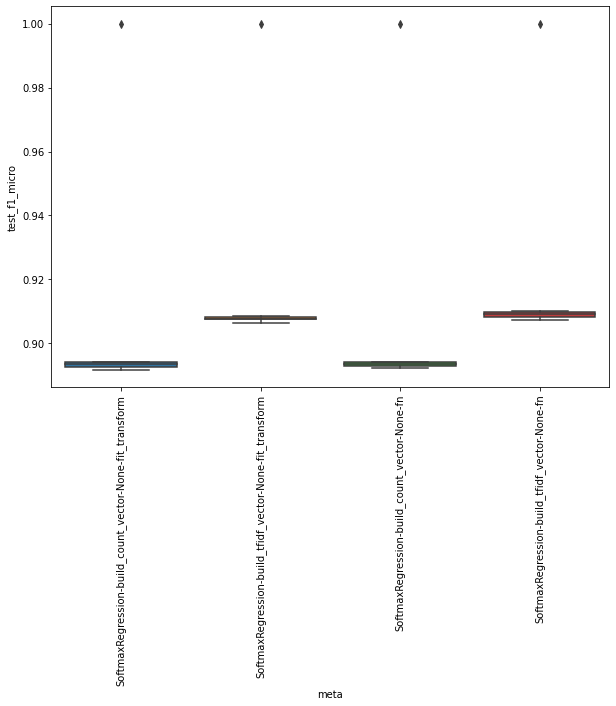

In [30]:
from matplotlib import pyplot
import seaborn as sns

a4_dims = (10, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.boxplot(data=analysis_df, x="meta", y="test_f1_micro")
g.set_xticklabels(labels=g.get_xticklabels(), rotation=90)

In [ ]:
analysis_df.to_csv("all_scratch_performance.csv", index=False)